In [1]:
import numpy as np
import pandas as pd 

In [2]:
cd /Users/wannjiun/Desktop/nycdsa/project_5_recommender/ml-latest-small

/Users/wannjiun/Desktop/nycdsa/project_5_recommender/ml-latest-small


In [3]:
df = pd.read_csv('ratings.csv', sep=',')
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
df_id = pd.read_csv('links.csv', sep=',')
df_id.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
num_users = df.userId.unique().shape[0]
num_movies = df.movieId.unique().shape[0]
print str(num_users) + ' users'
print str(num_movies) + ' movies'
print 'Max user id: ' + str(max(df.userId))  
print 'Max movie id: ' + str(max(df.movieId))   

671 users
9066 movies
Max user id: 671
Max movie id: 163949


In [6]:
ratings = np.zeros((num_users, max(df.movieId)))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings = ratings[:,:9000]
ratings.shape

(671, 9000)

In [7]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print 'Sparsity: {:4.2f}%'.format(sparsity)

Sparsity: 1.40%


In [8]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(
            ratings[user, :].nonzero()[0], 
            size=10, 
            replace=True)
        train[user, test_ratings] = 0.0
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [9]:
train, test = train_test_split(ratings)

In [10]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [11]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in xrange(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print '\tcurrent iteration: {}'.format(ctr)
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict_all(self):
        """ Predict ratings for every user and item. """
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in xrange(self.user_vecs.shape[0]):
            for i in xrange(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    def predict(self, u, i):
        """ Single user and item prediction. """
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
    
    def calculate_learning_curve(self, iter_array, test):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print 'Iteration: {}'.format(n_iter)
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print 'Train mse: ' + str(self.train_mse[-1])
                print 'Test mse: ' + str(self.test_mse[-1])
            iter_diff = n_iter

In [12]:
MF_ALS = ExplicitMF(train, n_factors = 20, user_reg = 0.1, item_reg = 0.1)
iter_array = [1, 2, 5, 10, 25, 50]
MF_ALS.calculate_learning_curve(iter_array, test)

In [13]:
class ExplicitMF():
    def __init__(self, 
                 ratings,
                 n_factors=40,
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        learning : (str)
            Method of optimization. Options include 
            'sgd' or 'als'.
        
        item_fact_reg : (float)
            Regularization term for item latent factors
        
        user_fact_reg : (float)
            Regularization term for user latent factors
            
        item_bias_reg : (float)
            Regularization term for item biases
        
        user_bias_reg : (float)
            Regularization term for user biases
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in xrange(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors,\
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors,
                                          size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter)
    
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print '\tcurrent iteration: {}'.format(ctr)
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            ctr += 1

    def sgd(self):
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            # Update biases
            self.user_bias[u] += self.learning_rate * \
                                (e - self.user_bias_reg * self.user_bias[u])
            self.item_bias[i] += self.learning_rate * \
                                (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += self.learning_rate * \
                                    (e * self.item_vecs[i, :] - \
                                     self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += self.learning_rate * \
                                    (e * self.user_vecs[u, :] - \
                                     self.item_fact_reg * self.item_vecs[i,:])
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in xrange(self.user_vecs.shape[0]):
            for i in xrange(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, test, learning_rate=0.1):
        """
        Keep track of MSE as a function of training iterations.
        
        Params
        ======
        iter_array : (list)
            List of numbers of iterations to train for each step of 
            the learning curve. e.g. [1, 5, 10, 20]
        test : (2D ndarray)
            Testing dataset (assumed to be user x item).
        
        The function creates two new class attributes:
        
        train_mse : (list)
            Training data MSE values for each value of iter_array
        test_mse : (list)
            Test data MSE values for each value of iter_array
        """
        iter_array.sort()
        self.train_mse =[]
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print 'Iteration: {}'.format(n_iter)
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print 'Train mse: ' + str(self.train_mse[-1])
                print 'Test mse: ' + str(self.test_mse[-1])
            iter_diff = n_iter

In [14]:
MF_SGD = ExplicitMF(train, 40, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100, 200]
MF_SGD.calculate_learning_curve(iter_array, test, learning_rate=0.001)

Iteration: 1
Train mse: 1.01545418724
Test mse: 1.10046477523
Iteration: 2
Train mse: 0.965822167151
Test mse: 1.05551220914
Iteration: 5
Train mse: 0.895468756033
Test mse: 0.9790022478
Iteration: 10
Train mse: 0.845640511467
Test mse: 0.922038858926
Iteration: 25
	current iteration: 10
Train mse: 0.786029076141
Test mse: 0.863579346417
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 0.742077009559
Test mse: 0.837386704284
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 0.620688014641
Test mse: 0.825260549854
Iteration: 200
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
Train mse: 0.326736797322
Test mse: 0.808131010412


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, label='Training', linewidth=2)
    plt.plot(iter_array, model.test_mse, label='Test', linewidth=2)
    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('Iterations', fontsize=16);
    plt.ylabel('MSE', fontsize=16);
    plt.legend(loc='best', fontsize=16);
    plt.title('Learning Curve', fontsize=16);

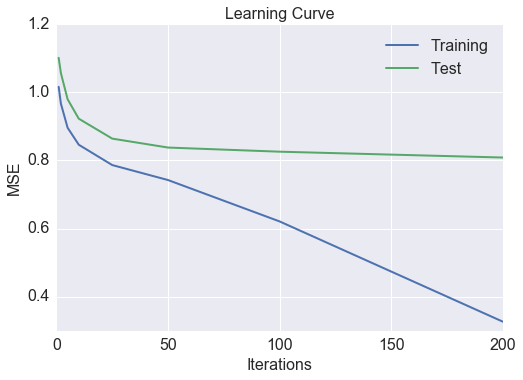

In [16]:
# plot_learning_curve(iter_array, MF_ALS)
plot_learning_curve(iter_array, MF_SGD)

In [17]:
def cosine_similarity(model):
    sim = model.item_vecs.dot(model.item_vecs.T)
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return sim / norms / norms.T

movie_similarity = cosine_similarity(MF_SGD)
print movie_similarity[:5, :5]
movie_similarity.shape

[[ 1.          0.04215218 -0.09996756 -0.03435615  0.16700641]
 [ 0.04215218  1.          0.16409853 -0.2732394   0.02845046]
 [-0.09996756  0.16409853  1.         -0.33051834  0.25866336]
 [-0.03435615 -0.2732394  -0.33051834  1.         -0.00815169]
 [ 0.16700641  0.02845046  0.25866336 -0.00815169  1.        ]]


(9000, 9000)

In [18]:
import requests
import json

In [19]:
import requests
import json

from IPython.display import Image
from IPython.display import display
from IPython.display import HTML

# Get base url filepath structure. w185 corresponds to size of movie poster.
headers = {'Accept': 'application/json'}
payload = {'api_key': 'bb3beb7ec7af6d1c0c23ca7381b62a89'} 
response = requests.get("http://api.themoviedb.org/3/configuration", params=payload, headers=headers)
response = json.loads(response.text)
base_url = response['images']['base_url'] + 'w185'

def get_poster(imdbid, base_url):
    # Get IMDB movie ID
    movie_id = "tt0" + str(imdbid) 
    
    # Query themoviedb.org API for movie poster path.
    movie_url = 'http://api.themoviedb.org/3/movie/{:}/images'.format(movie_id)
    headers = {'Accept': 'application/json'}
    payload = {'api_key': 'bb3beb7ec7af6d1c0c23ca7381b62a89'} 
    response = requests.get(movie_url, params=payload, headers=headers)
    try:
        file_path = json.loads(response.text)['posters'][0]['file_path']
    except:
        file_path = ""
        
    return (base_url + file_path, imdbid)   

In [20]:
# Load in movie data
idx_to_movie = {}
for row in df_id.itertuples():
    idx_to_movie[row[1]-1] = row[2]
idx_to_movie    
        
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [57]:
idx = 25
movie_similarity[np.isnan(movie_similarity)] = 0
movies = top_k_movies(movie_similarity, idx_to_movie, idx)
movies = filter(lambda imdb: len(str(imdb)) == 6, movies)
movies = movies[:5]

In [58]:
n_display = 5
URL = [0]*n_display
IMDB = [0]*n_display
i = 0
for movie in movies:
    (URL[i], IMDB[i]) = get_poster(movie, base_url)
    i += 1 
    
images = ''
for i in range(n_display):
    images += "<img style='width: 100px; margin: 0px; \
                float: left; border: 1px solid black;' src='%s' />" \
                % URL[i]

display(HTML(images))   